<a href="https://colab.research.google.com/github/gibranfp/CursoAprendizajeProfundo/blob/2023-1/notebooks/2e_autodiff_pytorch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Diferenciación automática
La [diferenciación automática](https://en.wikipedia.org/wiki/Automatic_differentiation) es un método para evaluar derivadas de funciones representadas como programas [[Automatic Differentiation in Machine Learning: a Survey, Baydin et. al, 2018](https://arxiv.org/abs/1502.05767)]. 

![Diferenciación automática](https://gowrishankar.info/blog/automatic-differentiation-using-gradient-tapes/auto_diff.png)

In [1]:
import torch as th
from torch import nn

import numpy as np
import matplotlib.pyplot as plt

import random

# Por reproducibilidad
th.manual_seed(42)
random.seed(42)
np.random.seed(42)

## Clase `Parameter`
La clase [`Parameter`](https://www.tensorflow.org/api_docs/python/tf/Variable) del módulo `nn` de PyTorch define una subclase de `Tensor` que se emplea comúnmente para representar los parámetros que modifican los algoritmos de aprendizaje para generar un modelo. Las instancias de `Parameter` que se definen dentro de una subclase de `Module` del módulo de `nn` se agregan a su lista de parámetros a optimizar.

El constructor de la clase `Parameter` recibe un tensor como argumento con el que se crea la instancia.


In [2]:
print(f'Con un tensor de ceros: {th.nn.parameter.Parameter(th.zeros((10,5)))}')
print(f'Con un tensor aleatorio: {th.nn.parameter.Parameter(th.rand((10,5)))}')
print(f'Con un arreglo de NumPy: {th.nn.parameter.Parameter(th.rand(5,5))}')
print(f'Con una lista: {th.nn.parameter.Parameter(th.tensor([[1.0, 2.0], [3.0, 4.0]]))}')

Con un tensor de ceros: Parameter containing:
tensor([[0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.]], requires_grad=True)
Con un tensor aleatorio: Parameter containing:
tensor([[0.8823, 0.9150, 0.3829, 0.9593, 0.3904],
        [0.6009, 0.2566, 0.7936, 0.9408, 0.1332],
        [0.9346, 0.5936, 0.8694, 0.5677, 0.7411],
        [0.4294, 0.8854, 0.5739, 0.2666, 0.6274],
        [0.2696, 0.4414, 0.2969, 0.8317, 0.1053],
        [0.2695, 0.3588, 0.1994, 0.5472, 0.0062],
        [0.9516, 0.0753, 0.8860, 0.5832, 0.3376],
        [0.8090, 0.5779, 0.9040, 0.5547, 0.3423],
        [0.6343, 0.3644, 0.7104, 0.9464, 0.7890],
        [0.2814, 0.7886, 0.5895, 0.7539, 0.1952]], requires_grad=True)
Con un arreglo de NumPy: Parameter containing:
tensor([[0.0050, 0

Podemos realizar cualquier operación tensorial con una instancia de `Parameter`, ya sea con otras instancias de `Parameter` o `Tensor`. El resultado de la operación es una instancia de `Tensor`.

In [3]:
param = th.nn.parameter.Parameter(th.zeros((10,5)))

print(f'Transpuesta: {param.T}')
print(f'Suma: {param + th.ones_like(param)}')
print(f'Multiplicación elemento a elemento: {param * th.zeros_like(param)}')
print(f'Multiplicación: {param @ th.rand_like(param).T}')

Transpuesta: tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]], grad_fn=<PermuteBackward0>)
Suma: tensor([[1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1.]], grad_fn=<AddBackward0>)
Multiplicación elemento a elemento: tensor([[0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.]], grad_fn=<MulBackward0>)
Multiplicación: 

Para modificar el contenido de una instancia de `Parameter` es necesario especificar que no se registre la operación por `autograd` usando el ámbito `no_grad`.

In [4]:
with th.no_grad():
  param[0, 0] = 1
param[0, 0]

tensor(1., grad_fn=<SelectBackward0>)

También existen métodos para instancias tanto de `Parameter` como de `Tensor` que modifican el contenido _in-place_. Los nombres de estos métodos usualmente terminan con un guión bajo. Tal es el caso de `add_` y `mul_`, que suman y multiplican un tensor.

In [5]:
with th.no_grad():
  print(param.add_(th.ones_like(param)))
  print(param.subtract_(th.ones_like(param)))
  print(param.add_(th.ones_like(param)))
  print(param.mul_(2 * th.ones_like(param)))

Parameter containing:
tensor([[2., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1.]], requires_grad=True)
Parameter containing:
tensor([[1., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.]], requires_grad=True)
Parameter containing:
tensor([[2., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1.],
        [1., 1., 1., 1

## Diferenciación automática en Tensorflow
PyTorch puede diferenciar automáticamente operaciones con instancias de `Tensor` o `Parameter`. Para ello crea un grafo de cómputo de las operaciones que se ejecutan con instancias que tienen la propiedad `requires_grad` en verdadero. Por defecto, todas las instancias de `Parameter` tienen esta propiedad en verdadero y las instancias de `Tensor` en falso.

In [6]:
ten = th.linspace(start=-10, end=10, steps=100)
print(param.requires_grad)
print(ten.requires_grad)

True
False


Es posible cambiar el valor de esta propiedad en una instancia usando el método `requires_grad_` (_in-place_).

In [7]:
param.requires_grad_(False)
ten.requires_grad_(True)
print(param.requires_grad)
print(ten.requires_grad)

False
True


Para obtener el gradiente de una [función escalar](https://en.wiktionary.org/wiki/scalar_function) respecto a un tensor que está siendo contemplado se debe llamar al método `backward`.

In [8]:
m = th.linspace(start=-10, end=10, steps=100, requires_grad=True)
suma = m.sum()
suma.backward()

Cuando se invoca a este método, se calculan los gradientes de la función respecto al tensor correspondiente y se acumulan en el tensor `grad` que es una propiedad de todas las instancia de `Tensor` y `Parameter`.

In [9]:
m, m.grad

(tensor([-10.0000,  -9.7980,  -9.5960,  -9.3939,  -9.1919,  -8.9899,  -8.7879,
          -8.5859,  -8.3838,  -8.1818,  -7.9798,  -7.7778,  -7.5758,  -7.3737,
          -7.1717,  -6.9697,  -6.7677,  -6.5657,  -6.3636,  -6.1616,  -5.9596,
          -5.7576,  -5.5556,  -5.3535,  -5.1515,  -4.9495,  -4.7475,  -4.5455,
          -4.3434,  -4.1414,  -3.9394,  -3.7374,  -3.5354,  -3.3333,  -3.1313,
          -2.9293,  -2.7273,  -2.5253,  -2.3232,  -2.1212,  -1.9192,  -1.7172,
          -1.5152,  -1.3131,  -1.1111,  -0.9091,  -0.7071,  -0.5051,  -0.3030,
          -0.1010,   0.1010,   0.3030,   0.5051,   0.7071,   0.9091,   1.1111,
           1.3131,   1.5152,   1.7172,   1.9192,   2.1212,   2.3232,   2.5253,
           2.7273,   2.9293,   3.1313,   3.3333,   3.5354,   3.7374,   3.9394,
           4.1414,   4.3434,   4.5455,   4.7475,   4.9495,   5.1515,   5.3535,
           5.5556,   5.7576,   5.9596,   6.1616,   6.3636,   6.5657,   6.7677,
           6.9697,   7.1717,   7.3737,   7.5758,   7

Una vez que se llama al método `.backward`, se elimina el grafo de cómputo. Sin embargo, es posible mantenerlo pasando el argumento `retain_graph=True` en la llamada. 

In [10]:
l = th.linspace(start=-10, end=10, steps=100, requires_grad=True)

suma = l.sum()
suma.backward(retain_graph=True) # acumula los gradientes en grad
print(l.grad) 
suma.backward() # acumula los gradientes en grad
print(l.grad) 

tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])
tensor([2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2.,
        2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2.,
        2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2.,
        2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2.,
        2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2.,
        2., 2., 2., 2., 2., 2., 2., 2., 2., 2.])


Múltiples llamadas a la función y al método `backward` acumulan los gradientes en `.grad`. Por lo mismo, en muchas ocasiones es necesarios ponerlos a 0 con el método (_in-pace_) `zero`.

In [11]:
with th.no_grad():
  l.grad.zero_()
l.grad

tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.])

También podemos diferenciar automáticamente respecto más de un tensor.

In [12]:
z = th.rand(size=(100,), requires_grad=True)
y = th.rand_like(z, requires_grad=True)
g = (z**2 + y).sum()
g.backward()

g, z, z.grad, y, y.grad

(tensor(77.8050, grad_fn=<SumBackward0>),
 tensor([0.2083, 0.3289, 0.1054, 0.9192, 0.4008, 0.9302, 0.6558, 0.0766, 0.8460,
         0.3624, 0.3083, 0.0850, 0.0029, 0.6431, 0.3908, 0.6947, 0.0897, 0.8712,
         0.1330, 0.4137, 0.6044, 0.7581, 0.9037, 0.9555, 0.1035, 0.6258, 0.2849,
         0.4452, 0.1258, 0.9554, 0.1330, 0.7672, 0.6757, 0.6625, 0.2297, 0.9545,
         0.6099, 0.5643, 0.0594, 0.7099, 0.4250, 0.2709, 0.9295, 0.6115, 0.2234,
         0.2469, 0.4761, 0.7792, 0.3722, 0.2147, 0.3288, 0.1265, 0.6783, 0.8870,
         0.0293, 0.6161, 0.7583, 0.5907, 0.3219, 0.7610, 0.7628, 0.6870, 0.4121,
         0.3676, 0.5535, 0.4117, 0.3510, 0.8196, 0.9297, 0.4505, 0.3881, 0.5073,
         0.4701, 0.6202, 0.6401, 0.0459, 0.3155, 0.9211, 0.6948, 0.4751, 0.1985,
         0.1941, 0.0521, 0.3370, 0.6689, 0.8188, 0.7308, 0.0580, 0.1993, 0.4211,
         0.9837, 0.5723, 0.3705, 0.7069, 0.3096, 0.1764, 0.8649, 0.2726, 0.3998,
         0.0026], requires_grad=True),
 tensor([0.4166, 0.6577, 0.2

Por otro lado, es posible obtener derivadas de orden mayor, pero esto se logra usando la función `grad` del módulo `autograd` en lugar del método `backward`.

In [13]:
z = th.rand(100, requires_grad=True)
f = (z**2).sum()
df = th.autograd.grad(f, z, create_graph=True)[0]
d2f = th.autograd.grad(df.sum(), z)[0]

z, f, df, d2f

(tensor([0.0991, 0.1583, 0.0066, 0.1142, 0.3764, 0.8374, 0.5837, 0.1197, 0.0989,
         0.7487, 0.1281, 0.4384, 0.7399, 0.2686, 0.4455, 0.4565, 0.3817, 0.2465,
         0.0543, 0.0958, 0.2323, 0.9829, 0.2585, 0.1642, 0.6212, 0.6378, 0.7740,
         0.8801, 0.7784, 0.0042, 0.5443, 0.8029, 0.4538, 0.2054, 0.9767, 0.3130,
         0.2153, 0.0492, 0.5223, 0.7216, 0.6107, 0.5989, 0.1208, 0.0331, 0.5088,
         0.9559, 0.7885, 0.2089, 0.4351, 0.1314, 0.2588, 0.5905, 0.7723, 0.9142,
         0.0409, 0.8343, 0.1474, 0.6872, 0.9231, 0.5070, 0.9549, 0.0740, 0.3090,
         0.7916, 0.3911, 0.3976, 0.2916, 0.8447, 0.7453, 0.6602, 0.2190, 0.0941,
         0.5541, 0.6481, 0.2691, 0.3601, 0.8377, 0.5398, 0.5226, 0.3769, 0.0472,
         0.0299, 0.2610, 0.2458, 0.6558, 0.3544, 0.3044, 0.9767, 0.6742, 0.8565,
         0.2579, 0.2958, 0.6838, 0.1669, 0.1731, 0.4759, 0.3171, 0.1252, 0.7966,
         0.9021], requires_grad=True),
 tensor(28.7066, grad_fn=<SumBackward0>),
 tensor([0.1981, 0.3166, 0.0

## Neurona artificial
La salida de una neurona artificial se obtiene multiplicando la transpuesta del vector columna de pesos $\mathbf{w}\in \mathbb{R}^d$ por el vector columna de entrada $\mathbf{x} \in \mathbb{R}^d$, sumando al final el valor del sesgo $b$ y evaluando el resultado con la función de activación $\phi$, esto es

$$
a = \phi\left(\mathbf{w}^\top \mathbf{x} + b\right)
$$

![Diagrama general de la neurona artificial](http://turing.iimas.unam.mx/~gibranfp/cursos/neurona.svg)

In [14]:
n = 100
d = 10

x = th.normal(size=(n,d), mean=0, std=1)
y = th.randint(low=0, high=2, size=(n, 1))

b = nn.parameter.Parameter(th.tensor([[1.]]))
w = nn.parameter.Parameter(th.normal(size=(d,1), mean=0, std=0.1))

def neurona_sigmoide(w, b, x):
  return th.sigmoid(x @ w + b)

Podemos obtener los gradientes de $\mathbf{w}$ y $b$ respecto a la [entropía cruzada binaria](https://en.wikipedia.org/wiki/Cross_entropy) usando diferenciación automática. La entropía cruzada binaria está dada por
$$
ECB(\mathbf{y}_k, \mathbf{\hat{y}}_k) = -\sum_{i=1}^N  \left[ y^{(i)}_k \log{\hat{y}^{(i)}_k} + (1 - y^{(i)}_k) \log{(1 - \hat{y}^{(i)}_k)} \right]
$$

In [15]:
def ecb(y, y_hat):
  perdida_ceros = th.log(y_hat[y == 0]).sum()
  perdida_unos = th.log(1.0 - y_hat[y == 1]).sum()
  return -(perdida_unos + perdida_ceros)

y_hat = neurona_sigmoide(w, b, x)
fp = ecb(y, y_hat)
fp.backward()

w.grad, b.grad

(tensor([[ -7.4935],
         [  2.5605],
         [  2.8493],
         [-10.7563],
         [ -3.3124],
         [ 10.9660],
         [ -5.7475],
         [ -7.6238],
         [  2.7905],
         [ -0.3388]]), tensor([[16.8596]]))

## Ejercicios
Genera un conjunto de datos sintético, programa la propagación hacia adelante y calcula los gradientes de la función de pérdida de la suma del error cuadrático medio respecto a los pesos y sesgos para $K$ regresiones lineales.

## Entrenando un modelo de regresión con descenso por gradiente
Vamos a entrenar un modelo de regresión lineal con [descenso por gradiente](https://youtu.be/IHZwWFHWa-w) usando la diferenciación automática de Tensorflow. 

Primero generamos un conjunto de datos sintético y lo almacenamos en una instancia de `Tensor`.

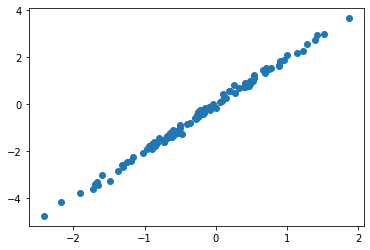

In [16]:
n = 100
x = th.randn(n, 1)
y = 2 * x + th.normal(size=(n, 1), mean=0, std=0.1)

plt.scatter(x.numpy()[:, 0], y.numpy()[:, 0])
plt.show()

Definimos las instancias de `Parameter` para $\mathbf{w}$ y $b$ las cuales inicializamos con valores aleatorios (normal con media 0 y desviación estándar 0.1) y con ceros, respectivamente.

In [17]:
w = nn.parameter.Parameter(th.normal(size=(1, 1), mean=0, std=0.1))
b = nn.parameter.Parameter(th.zeros(size=(1, 1)))
w, b

(Parameter containing:
 tensor([[-0.0209]], requires_grad=True), Parameter containing:
 tensor([[0.]], requires_grad=True))

Definimos una función para producir un tensor de salidas a partir de un tensor de entradas, esto es,
$$
\hat{y} = b + \mathbf{w}^\top\mathbf{x}.
$$


In [18]:
def neurona_lineal(w, b, x): 
  return x @ w + b

Ahora definimos nuestro ciclo de entrenamiento en el cual generamos la salida para cada entrada, calculamos los gradientes de $\mathbf{w}$ y $b$ respecto al error cuadrático medio usando la diferenciación automática de Tensorflow y finalmente actualizamos $\mathbf{w}$ y $b$ con la regla de actualización del descenso por gradiente:

$$
\boldsymbol{\theta}^{[t + 1]}   = \boldsymbol{\theta}^{[t]} - \alpha \nabla \mathcal{L}(\boldsymbol{\theta}^{[t]})
$$
donde 
$$
\begin{align*}
\boldsymbol{\theta} & = \{\mathbf{w}, \mathbf{b}\}\\
\nabla \mathcal{L}(\boldsymbol{\theta}^{[t]}) & = \left[  \frac{\partial \mathcal{L}}{\partial  \theta_0^{[t]}}, \cdots , \frac{\partial \mathcal{L}}{\partial \theta_d^{[t]}}\right]
\end{align*}
$$    

A $\alpha$ se le conoce como tasa de aprendizaje.


In [19]:
tasa = 0.1
hist = []
for e in range(100):
  y_hat = neurona_lineal(w, b, x)
  ecm = th.mean((y - y_hat)**2)
  ecm.backward() # calcula los gradientes de los tensores 

  # actualiza los parámetros (es necesario que esté en el ámbito no_grad)
  with th.no_grad(): 
    w += -tasa * w.grad
    b += -tasa * b.grad

    # Se limpian los gradientes para que no se acumulen
    w.grad.zero_()
    b.grad.zero_()

    hist.append(ecm.numpy())

Visualizamos el modelo.

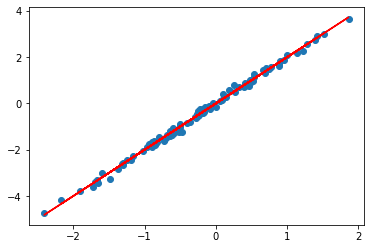

In [20]:
y_hat = neurona_lineal(w, b, x)

plt.scatter(x.numpy()[:, 0], y.numpy()[:, 0])
plt.plot(x.numpy()[:, 0], y_hat.detach().numpy()[:, 0], 'r')
plt.show()

Graficamos el valor de la pérdida por época.

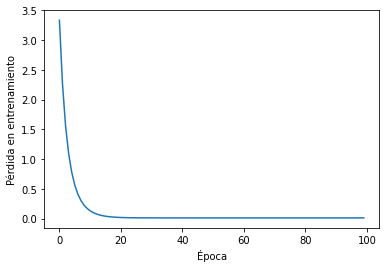

In [21]:
plt.plot(hist)
plt.xlabel('Época')
plt.ylabel('Pérdida en entrenamiento')
plt.show()

En el entrenamiento de redes neuronales profundas es común usar aproximaciones estocásticas del descenso por gradiente (o variaciones). Estas aproximaciones estiman $\nabla \mathcal{L}(\boldsymbol{\theta}^{[t]})$ y actualizan los parámetros (pesos y sesgos) usando un minilote $\mathcal{B}$ de ejemplos (en lugar de todo el conjunto) de entrenamiento, donde $\vert \mathcal{B} \vert$ es un hiperparámetro. Una estrategia para generar los lotes es dividir y ordenar aleatoriamente el conjunto de $n$ ejemplos de entrenamiento en $k$ minilotes ($\vert \mathcal{B} \vert \times k \approx n$) e ir tomando lotes consecutivos hasta pasar por todo el conjunto. Aquí una época ocurre cada vez que se han considerado los $k$ minilotes.

In [22]:
w = nn.parameter.Parameter(th.normal(size=(1, 1), mean=0, std=0.1))
b = nn.parameter.Parameter(th.zeros(size=(1, 1)))

tasa = 0.1
hist = []
t_lote = 10
n_lotes = 10
for e in range(100):
  perdida = 0
  # Generamos una permutación aleatoria del conjunto de entrenamiento
  perm = th.randperm(x.shape[0])
  xperm = x[perm]
  yperm = y[perm]

  # Vamos tomando lote por lote ejemplos del conjunto reordenado
  for lote in range(n_lotes): 
    y_hat = neurona_lineal(w, b, xperm[lote * t_lote:(lote + 1) * t_lote])
    ecm = th.mean((yperm[lote * t_lote:(lote + 1) * t_lote] - y_hat)**2)
    ecm.backward() # calcula los gradientes de los tensores 

    # actualiza los parámetros (es necesario que esté en el ámbito no_grad)
    with th.no_grad(): 
      w += -tasa * w.grad
      b += -tasa * b.grad

      # Se limpian los gradientes para que no se acumulen
      w.grad.zero_()
      b.grad.zero_()

      perdida += ecm.numpy()
    
    hist.append(perdida)

Visualizamos el modelo.

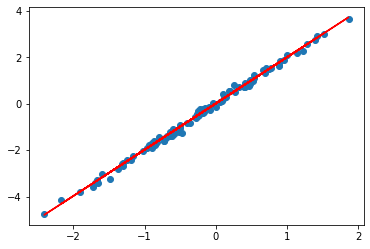

In [23]:
y_hat = neurona_lineal(w, b, x)

plt.scatter(x.numpy()[:, 0], y.numpy()[:, 0])
plt.plot(x.numpy()[:, 0], y_hat.detach().numpy()[:, 0], 'r')
plt.show()

Graficamos el valor de la pérdida por época.

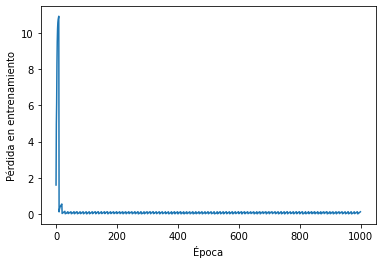

In [24]:
plt.plot(hist)
plt.xlabel('Época')
plt.ylabel('Pérdida en entrenamiento')
plt.show()